In [1]:
import os
import pickle
import datetime
import warnings

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold

import tensorflow as tf
import madmom
import mir_eval

from segment import segment_spectrogram
from modules.labels import get_label_vector
from modules.madmom_cnn_prep import cnn_preprocessor, cnn_normalize
from modules.analysis_funcs import get_idx_to_fold, get_segmented_data
from datasets import Dataset
from analyze_detection import evaluate, f_score
from models.bock2013pret import get_model

%load_ext autoreload
%autoreload 2

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

SR = 44100
FPS = 100
CONTEXT = 7

/home/simonf/.venv/onsets/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
ds = pd.read_csv("datasets/metadata.csv", index_col=0)
ds

,filename,length (s),player,category,vibrato,polyphony
0,slurtest01.wav,16.962177,SA,scales,0,0
1,slurtest02.wav,16.195918,SA,scales,0,0
2,slurtest03.wav,16.567438,SA,scales,0,0
3,slurtest04.wav,15.961088,SA,scales,0,0
4,slurtest05.wav,34.098503,SA,arpeggios,0,0
5,slurtest06.wav,49.621043,SA,arpeggios,0,0
6,slurtest07.wav,49.737143,SA,arpeggios,0,0
7,slurtest08.wav,29.141043,SA,songs,0,1
8,slurtest09.wav,36.223129,SA,scales,1,0
9,slurtest10.wav,40.251791,SA,songs,1,0


In [4]:
sel = [0,2,3,4,8, 21,34,24,42,26, 29,22,30,47,44]
ds.iloc[sel]

,filename,length (s),player,category,vibrato,polyphony
0,slurtest01.wav,16.962177,SA,scales,0,0
2,slurtest03.wav,16.567438,SA,scales,0,0
3,slurtest04.wav,15.961088,SA,scales,0,0
4,slurtest05.wav,34.098503,SA,arpeggios,0,0
8,slurtest09.wav,36.223129,SA,scales,1,0
21,slurtest01_IR2.wav,18.501134,IR,scales,0,0
34,slurtest03_IR1.wav,19.161905,IR,scales,0,0
24,slurtest04_IR2.wav,18.184671,IR,scales,0,0
42,slurtest05_IR1.wav,57.145782,IR,arpeggios,0,0
26,slurtest09_IR2.wav,35.647075,IR,scales,0,0


In [5]:
# Load data
#ds0 = Dataset("initslurtest")
#ds1 = Dataset("slurtest_add_1")
#ds2 = Dataset("slurtest_add_2")
#ds3 = Dataset("slurtest_test")
#audio_fnames = ds0.get_audio_paths() #+ ds1.get_audio_paths() + ds2.get_audio_paths() + ds3.get_audio_paths()

data_dir = "datasets/augmented/"

audio_fnames = [data_dir + fname  for fname in ds.iloc[sel]["filename"]]
label_fnames = [data_dir + fname[:-4] + ".txt"  for fname in ds.iloc[sel]["filename"]]


audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]
for ele in sample_rates:
    if ele != SR:
        print("Some sample rates are not equal to 44.1kHz!")

# TODO migrate to mixed dataset (not based on recordings)


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [6]:
# Load preprocessing funciton
preprocessor = cnn_preprocessor()
box_processor = madmom.features.onsets.CNNOnsetProcessor()

In [65]:
# TODO enable augmentation, skip cell for now
# Add white noise to recordings
# Noise variance is adjusted to a fixed Signal Noise Ratio computed recording-wise
# snr_db = 20 means S/N=10
# snr_db = 10 means S/N≈3.2
SNR_DB = 10
snr_v = 10**(SNR_DB/20)

def augmentation(audio, t=None, p=None):
    if t==None:
        return audio
    elif t=="white_noise":
        # p contains snr_db parameter
        return audio+np.random.normal(
            scale=madmom.audio.signal.root_mean_square(audio)/(10**(p/20)),
            size=audio.shape
            )

for audio, fname in zip(audios, audio_fnames):
    np.save("dataset/augmented/" + os.path.basename(fname) + "_noise_SNRdB_"+SNR_DB)





TypeError: can only concatenate str (not "int") to str

In [7]:
# Prepare onehot vectors (y)
onset_vectors = [get_label_vector(sched, len(audio)/sr, FPS)
    for (sched, audio, sr) in zip(onset_schedules, audios, sample_rates)
]

In [8]:
fuzzy_onsets = []
for vec in onset_vectors:
    center = vec*0.5
    right = np.concatenate((vec[1:], [0]))*0.25
    left = np.concatenate(([0], vec[:-1]))*0.25
    fuzzy_onsets.append(center+right+left)


In [9]:
# Create data and normalize (X)
mm_proc_frames = [preprocessor(fname) for fname in audio_fnames]
mm_frames_normalized = [cnn_normalize(frame_set) for frame_set in mm_proc_frames]


In [10]:
def data_generator(
    batch_size,
    steps_per_epoch,
    epochs,
    idx, 
    sampling=True,
    mode=None,
    standard=False,
    mean=None,
    std=None, 
    single_channel=False
):
    
    #for _ in range(steps_per_epoch * epochs):
    if not sampling:
        ep = 0
        file_p = 0
        frame_p = 0
    
    while True:
        # Select indices for training or test
        if sampling:
            file_i = np.random.choice(idx)
        else:
            file_i = idx[file_p]
        
        #print("Selected file index: ", file_i)
        fname = audio_fnames[file_i]
        
        if mode=="use_prep_frames":
            frames = mm_frames_normalized[file_i]
        elif mode=="use_raw_frames":
            # No normalization
            frames = mm_proc_frames[file_i]    
        else:
            # Compute frames
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fxn()
                frames = cnn_normalize(preprocessor(fname))

        if standard:
            frames = (frames-mean)/std
            
        #print("Frame size: ", frames.shape[0])

        # Retrieve onsets 
        onsets = onset_vectors[file_i]
        #print("Computed frames of size ", frames.shape)
        #print("Onset vectors have len ", len(onsets))

        # Sample a set of indices (defined from audio start,
        # that is CONTEXT values counted from x array start)
        if sampling:
            focus_idx = np.random.choice(
                np.arange(frames.shape[0]-2*CONTEXT-1), 
                size=batch_size
            )
            #print("Sampled focus idx between ", 0, " and ", frames.shape[0]-2*CONTEXT-1)
        else:
            #print("Focus idx from ", frame_p, " to ", frame_p+batch_size)
            focus_idx = np.arange(frame_p, frame_p+batch_size)
        

        # Segmentation
        x = [frames[focus:focus+2*CONTEXT+1,:,:] for focus in focus_idx]
        if single_channel:
            x = np.transpose(np.stack(x,0)[:,:,:,0], [0,2,1])
        else:   
            x = np.transpose(np.stack(x, 0), [0,2,1,3])
        #print("Segmented x has shape ", x.shape)
        if x.shape[0] != batch_size:
            print("Delivering less than batch-size")

        # Labels
        y = onsets[focus_idx]
        yield (x, y)

        if not sampling:
            if frame_p + 2*batch_size >= frames.shape[0]-2*CONTEXT-1:
                if file_p == len(idx) - 1:
                    ep += 1
                    print("Generator reached end of epoch. Resetting...")
                    file_p = 0
                    frame_p = 0
                else:
                    file_p += 1
                    frame_p = 0
            else:
                frame_p += batch_size
            

In [11]:
for i, name in enumerate(audio_fnames):
    print(i, os.path.basename(name), end="  ")

0 slurtest01.wav  1 slurtest03.wav  2 slurtest04.wav  3 slurtest05.wav  4 slurtest09.wav  5 slurtest01_IR2.wav  6 slurtest03_IR1.wav  7 slurtest04_IR2.wav  8 slurtest05_IR1.wav  9 slurtest09_IR2.wav  10 slurtest01_FK1.wav  11 slurtest03_FK1.wav  12 slurtest04_FK1.wav  13 slurtest05_FK.wav  14 slurtest09_FK1.wav  

In [12]:
# Custom split:
n_splits = 1
split_at_rec = 9
#folds = [[np.arange(split_at_rec), np.arange(split_at_rec, len(audio_fnames))]]
folds = [[[0,1,2,3,4,10,11,12,13,14], [5,6,7,8,9]]]
folds = [[[0,1,2,3,4,10,11,12,13,14, 5,6,7,8], [9]]]


In [ ]:
# Stratified musician-wise
sa_recs = list(np.arange(19)) + [23, 25, 28, 32, 36, 37, 45, 46]
fk_recs = [22, 29, 30, 33, 44, 47]
ir_recs = np.setdiff1d(list(np.arange(49)), sa_recs + fk_recs)

random_seed = 119
n_splits = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

folds = list(skf.split(
    np.concatenate((sa_recs, ir_recs)), # Indices in devset
    np.concatenate((np.zeros(len(sa_recs)), np.ones(len(ir_recs)))) # Boolean whether recs are played by a certain musician
))


In [ ]:
# Basic k-Fold
random_seed = 119
n_splits =  5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=True)
folds = list(kf.split(np.arange(len(audio_fnames))))

In [18]:
# Precompute statistics
means_per_fold = []
std_per_fold = []
onset_ratios = []
for train_idx, test_idx in folds:
    train_frames = np.concatenate([mm_proc_frames[i] for i in train_idx]) 
    mean_train = train_frames.mean(0)
    std_train = train_frames.std(0, ddof=1)
    means_per_fold.append(np.expand_dims(mean_train, axis=0))
    std_per_fold.append(np.expand_dims(std_train, axis=0))

#with open('results/computed/added_means_by_fold.pickle', 'wb') as file_pi:
#    pickle.dump(means_per_fold, file_pi)
#with open('results/computed/added_std_by_fold.pickle', 'wb') as file_pi:
#    pickle.dump(std_per_fold, file_pi)



In [19]:
def compute_steps(idx, bs):
    song_sizes = np.array([len(f) for f in mm_proc_frames])[idx]-2*CONTEXT-1
    steps_per_song = np.floor_divide(song_sizes, bs)
    return np.sum(steps_per_song)

In [20]:
# Hyperparameters and modes
datasets = "full"
continue_run = False
training_mode = 0 # REMEMBER TO CHANGE
check_at_epoch = 1

custom_model = False

save = False # REMEMBER TO CHANGE
 # REMEMBER TO CHANGE
save_path = "results/cnn-training-220425/" # TODO - automatically
n_epochs = 10 # REMEMBER TO CHANGE
learning_r = 0.001
bs = 256
steps_per_epoch = int(np.sum(np.array([len(f) for f in mm_proc_frames])[folds[0][0]]-2*CONTEXT-1)/bs)
val_steps_per_epoch = 100
nogen = False
sampling = False
l2_lambda = 0 # DEFAULT: 0.01
dropout_p = 0.8

# Class weighting (on all data)
W = np.sum([len(vec) for vec in onset_vectors])/np.sum([vec.sum() for vec in onset_vectors])

finetune = False

standard = True # keep in mind on which data format statistics are computed 
mode = 'use_prep_frames' # Preparing by BN layer/"CNN normalization"
mode = 'use_raw_frames' # No preparing


training_name = "{}-{}-{}eps-lr{:.4f}-{}".format(
    datasets, 
    "nogen" if nogen else ("sample" if sampling else "seq"),
    n_epochs,
    learning_r,
    "standard" if standard else "nostandard"
)


In [15]:
W

37.513169845594916

In [153]:
# Keep for now but might remove later
from modules.analysis_funcs import get_test_peaks
tf.config.run_functions_eagerly(True)
class DetectionMetrics(tf.keras.metrics.Metric):

  def __init__(self, name='binary_true_positives', **kwargs):
    super(DetectionMetrics, self).__init__(name=name, **kwargs)
    self.cd = self.add_weight(name='cd', initializer='zeros')
    self.fp = self.add_weight(name='fp', initializer='zeros')
    self.fn = self.add_weight(name='fn', initializer='zeros')

  @tf.function
  def update_state(self, y_true, y_pred, sample_weight=None):
    #print((y_pred.numpy()>.5).astype(int).reshape((1,-1)))
    peaks = get_test_peaks(y_pred, 0.01)
    
    size = K.int_shape(y_true)[0]
    true_times = tf.where(K.reshape(y_true, (-1)) == 1)/FPS
    [CD,FN,FP,doubles,merged] = evaluate(true_times.numpy().reshape(-1), peaks, tol_sec=0.03)
    self.fp.assign_add(FP)
    self.fn.assign_add(FN)
    self.cd.assign_add(CD)

  def reset_state(self):
    self.cd.assign(0)
    self.fp.assign(0)
    self.fn.assign(0)

class DetectionPrecision(DetectionMetrics):

  def __init__(self, name='precision', **kwargs):
    super(DetectionPrecision, self).__init__(name=name, **kwargs)

  def result(self):
    if self.fp+self.cd>0:
      prec =self.cd/(self.fp+self.cd)
    else:
      prec = np.nan
    return prec

class DetectionRecall(DetectionMetrics):

  def __init__(self, name='recall', **kwargs):
    super(DetectionRecall, self).__init__(name=name, **kwargs)

  def result(self):
    if self.fn+self.cd>0:
      rec =self.cd/(self.fn+self.cd)
    else:
      rec = np.nan
    return rec

class CorrectDetections(DetectionMetrics):

  def __init__(self, name='CDs', **kwargs):
    super(CorrectDetections, self).__init__(name=name, **kwargs)

  def result(self):
    return self.cd

tf.config.run_functions_eagerly(True)
prec_metric = DetectionPrecision()
rec_metric = DetectionRecall()

In [21]:
# Metrics and loss
def wbce(y_true, y_pred):
        y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1-1e-7)
        logits = tf.keras.backend.log(y_pred/(1-y_pred))
        return tf.nn.weighted_cross_entropy_with_logits(
            y_true, logits, W
)

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
metrics = [
    wbce
    #prec,
    #rec
]

In [155]:
# Custom model mode
from keras.regularizers import l2

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(80, 15)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, 
            trainable = True,
            activation = "sigmoid",
            kernel_regularizer=l2(l2_lambda),
            bias_regularizer=l2(l2_lambda)
        ),
        tf.keras.layers.Dense(64, 
            trainable = True,
            activation = "sigmoid",
            kernel_regularizer=l2(l2_lambda),
            bias_regularizer=l2(l2_lambda)
        ),
        tf.keras.layers.Dense(1, 
            activation = "sigmoid",
            kernel_regularizer=l2(l2_lambda),
            bias_regularizer=l2(l2_lambda)
    )  
    ])

In [22]:
# Training cell

from numpy import single

if isinstance(training_mode, int):
    fold = training_mode
else:
    fold = 0

while fold < n_splits:
    print()
    print("Fold {}/{} ---------".format(fold, n_splits))
    train_idx = folds[fold][0]
    test_idx = folds[fold][1]
    print("Train indices: ", train_idx)
    print("Test indices: ", test_idx)

    # Data
    if nogen:
        X_train, X_test = [
            np.concatenate([mm_frames_normalized[i] for i in idx]) 
            for idx in (train_idx, test_idx)
        ]
        y_train, y_test = [
            np.concatenate([onset_vectors[i] for i in idx]) 
            for idx in (train_idx, test_idx)
        ]

    #train_onset_ratio = y_train.sum()/len(y_train)

    # Normalize with training set statistics
    if standard:
        mean = means_per_fold[fold]
        std = std_per_fold[fold]
    else:
        mean, std = None, None

    # Model
    if not continue_run:
        tf.keras.backend.clear_session()
    if custom_model:
        model = model 
    else:
        (model, norm_layer)=get_model(finetune=finetune, l2_lambda=l2_lambda, dropout_p=dropout_p)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=metrics)
                
    if not sampling:
        steps_per_epoch = compute_steps(train_idx, bs)
        val_steps_per_epoch = compute_steps(test_idx, bs)
        print(steps_per_epoch, val_steps_per_epoch)

    if nogen:
        x = X_train
        y = y_train
        steps_per_epoch = None
        validation_data = (X_test, y_test)
    else:
        x = data_generator(
            batch_size=bs, 
            steps_per_epoch=steps_per_epoch, 
            epochs=n_epochs,
            idx=train_idx,
            sampling=sampling,
            mode=mode,
            standard=standard, mean=mean, std=std,
            single_channel=custom_model
        )
        y = None
        validation_data = data_generator(
            batch_size=bs, 
            steps_per_epoch=val_steps_per_epoch, 
            epochs=n_epochs,
            idx=test_idx,
            sampling=sampling,
            mode=mode,
            standard=standard, mean=mean, std=std,
            single_channel=custom_model
        )

    checkpoint_path = save_path + 'fold_{}_{}'.format(fold,training_name)+"_cp_{epoch:04d}.ckpt"
    if check_at_epoch is None:
        cp_callback=[]
    else:
        cp_callback = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                    save_weights_only=True,
                                                    save_freq=int(steps_per_epoch*check_at_epoch))]
    # Training
    history = model.fit(
        x = x, y = y, 
        steps_per_epoch = steps_per_epoch,
        epochs          = n_epochs,
        # Validation data
        validation_data = validation_data,
        validation_steps  = val_steps_per_epoch,
        class_weight = {0:1, 1:1/0.035}, # {0:1, 1:W}
        callbacks=[cp_callback],
        verbose=1
    )

    # Saving
    if save:
        model.save(save_path + 'fold_{}_{}_model'.format(fold, training_name))
        with open(save_path + 'fold_{}_{}_history.pickle'.format(fold, training_name), 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    
    
    if training_mode != "all":
        break
    fold += 1


Fold 0/1 ---------
Train indices:  [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 5, 6, 7, 8]
Test indices:  [9]
142 13
Epoch 1/10


2023-01-09 15:05:29.736636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:05:29.741286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:05:29.741612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:05:29.742318: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

142/142 [==============================] - 3s 14ms/step - loss: 2.0961 - wbce: 2.6030 - val_loss: 0.3125 - val_wbce: 0.5321
Epoch 2/10
142/142 [==============================] - 2s 13ms/step - loss: 1.0473 - wbce: 1.2351 - val_loss: 0.2432 - val_wbce: 0.4963
Epoch 3/10
142/142 [==============================] - 2s 13ms/step - loss: 0.8112 - wbce: 0.9503 - val_loss: 0.2426 - val_wbce: 0.4958
Epoch 4/10
142/142 [==============================] - 2s 13ms/step - loss: 0.7478 - wbce: 0.8782 - val_loss: 0.2234 - val_wbce: 0.4741
Epoch 5/10
142/142 [==============================] - 2s 13ms/step - loss: 0.6780 - wbce: 0.7922 - val_loss: 0.2095 - val_wbce: 0.4495
Epoch 6/10
142/142 [==============================] - 2s 13ms/step - loss: 0.6514 - wbce: 0.7603 - val_loss: 0.2159 - val_wbce: 0.4467
Epoch 7/10
142/142 [==============================] - 2s 13ms/step - loss: 0.6177 - wbce: 0.7195 - val_loss: 0.2110 - val_wbce: 0.4431
Epoch 8/10
142/142 [==============================] - 2s 13ms/step

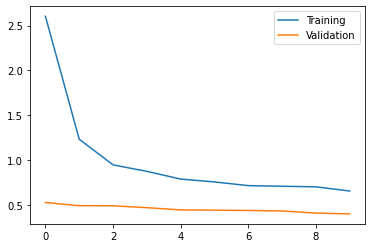

In [23]:
plt.plot(history.history['wbce'])
plt.plot(history.history['val_wbce'])
plt.legend(["Training", "Validation"])

In [24]:
TOL = 0.025
epochs = np.arange(1, n_epochs, check_at_epoch) #np.arange(20,520,20)
score_at_ep = np.zeros((len(folds), len(audios), len(epochs), 3))
peakss = []
outs = []

for fold_i, (train_idx, test_idx) in enumerate(folds):
    for r in test_idx:
        rec_name = os.path.basename(audio_fnames[r])
        #rec_name = "datasets/extra/HahnGiguePartita2.mp3"
        print(rec_name)
        sig = madmom.audio.Signal(audio_fnames[r])
        x = get_segmented_data(audio_fnames[r])

        for cp_i, epoch in enumerate(epochs):
            model.load_weights(save_path + 'fold_{}_{}'.format(fold,training_name)+"_cp_{:04d}.ckpt".format(epoch))
            out = model.predict(x)
            outs.append(out)
            peaks = madmom.features.onsets.peak_picking(
                                        activations=out, 
                                        threshold=0.5, 
                                        smooth=7, 
                                        pre_avg=1, 
                                        post_avg=5, 
                                        pre_max=1, 
                                        post_max=5
                    )[0].astype(np.float32)/FPS
            peakss.append(peaks)
            scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
            score_at_ep[fold_i, r, cp_i, 0] = scores["F-measure"]
            score_at_ep[fold_i, r, cp_i, 1] = scores["Precision"]
            score_at_ep[fold_i, r, cp_i, 2] = scores["Recall"]
            print("Ep "+str(epoch) + "\t" + "F {:.2f} P {:.2f} R {:.2f}".format(
                100*scores["F-measure"],100*scores["Precision"],100*scores["Recall"]))


datasets/extra/HahnGiguePartita2.mp3


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Ep 1	F 83.78 P 75.61 R 93.94
Ep 2	F 83.22 P 74.70 R 93.94
Ep 3	F 83.12 P 72.73 R 96.97
Ep 4	F 84.77 P 75.29 R 96.97
Ep 5	F 84.21 P 74.42 R 96.97
Ep 6	F 83.66 P 73.56 R 96.97
Ep 7	F 84.21 P 74.42 R 96.97
Ep 8	F 83.66 P 73.56 R 96.97
Ep 9	F 84.21 P 74.42 R 96.97


In [182]:
print("Mean f-score: ", score_at_ep[0, :, -1, 0].sum()/5)

Mean f-score:  0.8809475832760674


In [35]:
from modules.vis import onset_visualizer, passage_extractor
begin = 0
end = 7.5
R = 0

#test_audio, test_sr = madmom.audio.signal.load_audio_file("datasets/extra/HahnGiguePartita2.mp3")

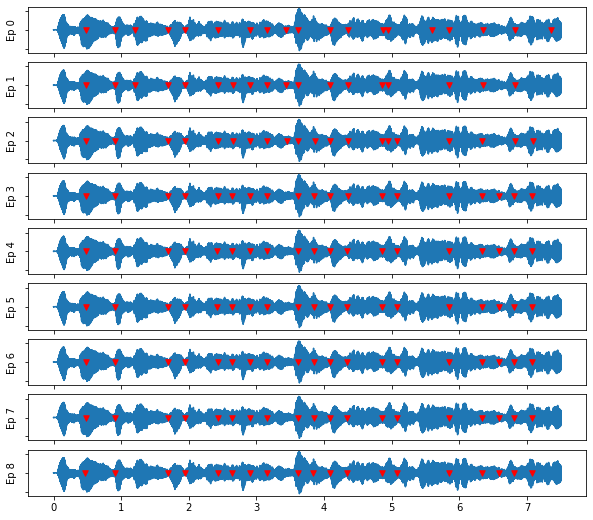

In [37]:
pred_color = "red"
fig,axs = plt.subplots(len(epochs), 1, figsize=(10,len(epochs)), sharex=True)
for ep_i, ax in enumerate(axs):
    passage = passage_extractor(audios[R],
            [ 
                peakss[ep_i]      # added here
            ],
        [begin,end],
        sr=sample_rates[R]
    )[0]
    onset_visualizer(passage=passage, ax=ax, onset_styles={"m":["v"], "c":[pred_color]})
    ax.set_ylabel("Ep "+ str(ep_i))
    ax.set_yticklabels([])

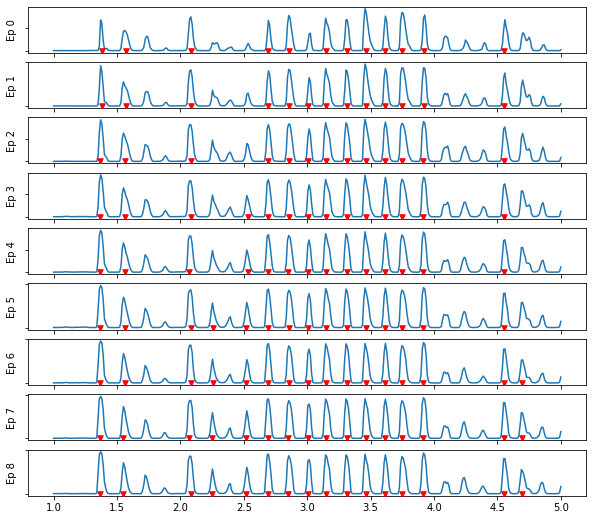

In [178]:
fig,axs = plt.subplots(len(epochs), 1, figsize=(10,len(epochs)), sharex=True)
for ep_i, ax in enumerate(axs):
    passage = passage_extractor(outs[ep_i],
            [ 
                peakss[ep_i]      # added here
            ],
        [begin,end],
        sr=100
    )[0]
    onset_visualizer(passage=passage, ax=ax, onset_styles={"m":["v"], "c":[pred_color]})
    ax.set_ylabel("Ep "+ str(ep_i))
    ax.set_yticklabels([])